In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from ROOT import TFile, TTree

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC


Welcome to JupyROOT 6.28/00


In [2]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)

nsigma_extend=3
thresh=1e1

In [3]:

# Open ROOT FIle
f = TFile.Open("../../data/simOut_28796KShell.root")

### Function

In [3]:
def getData(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2

    for i, evt in enumerate(f.data):
        if i == saveevt:
            x = np.asarray(evt.x) / 10 + center_z / 10
            y = np.asarray(evt.y) / 10 + center_z / 10
            z = np.asarray(evt.z) / 10 + center_z / 10
            Edep = np.asarray(evt.edep) * 1000
            PrimaryEvt = np.stack((x, y, z, Edep))
            break
    return PrimaryEvt

# def getData2(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2
    
    
    # Shift Coordinate
    for i, evt in enumerate(f.data):
        x = np.asarray(evt.x) / 10 + center_z / 10
        y = np.asarray(evt.y) / 10 + center_z / 10
        z = np.asarray(evt.z) / 10 + center_z / 10
        Edep = np.asarray(evt.edep) * 1000
        PrimaryEvt = np.stack((x, y, z, Edep))
        if i == saveevt:
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    nip_list = np.random.poisson(PrimaryEvt[3]/det.wval)
    return np.append(PrimaryEvt, [nip_list], axis=0)


def driftCarriers(PrimaryEvtNIP, det):
    NIP = PrimaryEvtNIP[4].astype(int)
    z_list = PrimaryEvtNIP[2].repeat(NIP)
    DriftedEvt = np.array([
        np.arange(len(NIP)).repeat(NIP),
        PrimaryEvtNIP[0].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        PrimaryEvtNIP[1].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        PrimaryEvtNIP[2].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
    ])
    return DriftedEvt


def gainAndReadout(DriftedEvt, det, nsigma_extend=3, thresh=1e1):
    minvals = np.array([DriftedEvt[1].min(),DriftedEvt[2].min(), DriftedEvt[3].min() ])
    maxvals = np.array([DriftedEvt[1].max(),DriftedEvt[2].max(), DriftedEvt[3].max() ])
    nsigma_extend = 3
    PSFmean_extend = nsigma_extend * det.PSFstd + det.PSFmean
    x_range = (minvals[0] - PSFmean_extend, maxvals[0] + PSFmean_extend)
    y_range = (minvals[1] - PSFmean_extend, maxvals[1] + PSFmean_extend)
    dt_range = (minvals[2] - nsigma_extend * det.gain_sigma_t, maxvals[2] + nsigma_extend * det.gain_sigma_t)
    # Calculate ReadoutGrid
    ReadoutGrid = np.mgrid[
                np.floor(x_range[0] / det.pitch_x) * det.pitch_x:
                np.ceil(x_range[1] / det.pitch_x) * det.pitch_x:
                det.pitch_x,
                np.floor(y_range[0] / det.pitch_y) * det.pitch_y:
                np.ceil(y_range[1] / det.pitch_y) * det.pitch_y:
                det.pitch_y,
                np.floor(dt_range[0] / det.samplerate) * det.samplerate:
                np.ceil(dt_range[1] / det.samplerate) * det.samplerate:
                det.samplerate
                ]

    pos = np.stack(ReadoutGrid, axis=3)
    ReadoutEvt = None
    for i in range(len(DriftedEvt[1])):
        thisGain = np.random.exponential(scale=det.gain_mean)
        rv = multivariate_normal([DriftedEvt[1][i], DriftedEvt[2][i], DriftedEvt[3][i]], np.diag([det.PSFstd, det.PSFstd, det.gain_sigma_t]))
        if ReadoutEvt is None:
            #The factor pitch_x*pitch_y*sample_rate converts from probability density 
            #to 'normalised' probability
            ReadoutEvt = rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
        else:
            ReadoutEvt += rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
    themask = ReadoutEvt >= thresh
    if np.sum(themask) == 0:
        print('No channels above threshold!')
        return pd.DataFrame(columns=['x', 'y', 'dt', 'Nel'])
    try:
        return pd.DataFrame({'x': ReadoutGrid[0][themask].flatten(), 'y': ReadoutGrid[1][themask].flatten(), 
            'dt': ReadoutGrid[2][themask].flatten(), 'Nel': ReadoutEvt[themask]})
    except:
        print(f'DriftedEvt: {DriftedEvt}')
        print(f'themask: {themask}\nReadoutGrid[0]: {ReadoutGrid[0]}\nReadoutEvt: {ReadoutEvt}\nReadoutGrid: {ReadoutGrid}')
        print(f'ReadoutGrid.shape: {ReadoutGrid.shape}, ReadoutEvt.shape: {ReadoutEvt.shape}, themask.shape = {themask.shape}')
        raise

def printPrimary(PrimaryEvt):
    print(' x        y        z       Edep   ')
    for i in range(len(PrimaryEvt[0])):
        x = PrimaryEvt[0][i]
        y = PrimaryEvt[1][i]
        dt = PrimaryEvt[2][i]
        Edep = PrimaryEvt[3][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}')

def printPrimaryNIP(PrimaryEvtNIP):
    print(' x       y        z        Edep    NIP')
    for i in range(len(PrimaryEvtNIP[0])):
        x = PrimaryEvtNIP[0][i]
        y = PrimaryEvtNIP[1][i]
        dt = PrimaryEvtNIP[2][i]
        Edep = PrimaryEvtNIP[3][i]
        NIP = PrimaryEvtNIP[4][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}  {NIP:.0f} ')

def printDrifted(DriftedEvt):
    print('pidx   x        y        dt')
    for i in range(len(DriftedEvt[0])):
        pidx = DriftedEvt[0][i]
        x = DriftedEvt[1][i]
        y = DriftedEvt[2][i]
        dt = DriftedEvt[3][i]
        print(f'{pidx:.0f}      {x:.4f}  {y:.4f}  {dt:.4f} ')


def plotReadout(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*1000)
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*1000)
    plt.title(" X-dT Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*1000)
    plt.title(" Y-dT Chart ")
    # plt.savefig('export/chart_Y-dT.png')

    plt.show()

In [47]:
# Define the Detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")


std = det.PSFstd = 0.1
pitch_x = 1
pitch_y = 1
pitch_z = 0.1
thresh = 1e-20
grid_size = 100
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))
N = 20

# Function Definition
def getDistribution(grid_size, offset):
    x, y, z = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
            -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y,
            -grid_size*pitch_z:(grid_size+1)*pitch_z:pitch_z,
            ]
    offset_x, offset_y, offset_z = offset

    # gain = np.random.exponential(scale=det.gain_mean)
    gain = 1
    C = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    G = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    B = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    F = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    D = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    H = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    A = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y, z+pitch_z/2-offset_z])), axis=-1)
    E = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y, z-pitch_z/2-offset_z])), axis=-1)
    # val_substract = rv.cdf(A) - rv.cdf(E)
    # The Intuitive Equation:  val = (rv.cdf(C) - rv.cdf(G)) - ( (rv.cdf(B) - rv.cdf(F)) - val_substract ) - ( (rv.cdf(D) - rv.cdf(H)) - val_substract ) - val_substract
    print('time cdf: ')
    %timeit val = (rv.cdf(C) - rv.cdf(G)) -  (rv.cdf(B) - rv.cdf(F)) - (rv.cdf(D) - rv.cdf(H)) + rv.cdf(A) - rv.cdf(E)
    
    print('time pdf')
    %timeit val = rv.pdf(np.stack((x, y, z), axis = -1))*pitch_x*pitch_y*pitch_z*gain
    
    val = rv.pdf(np.stack((x, y, z), axis = -1))*pitch_x*pitch_y*pitch_z*gain
    # gain=1 #not considering gain effect for temporary
    # val_cdf = (rv.cdf(top_right) - rv.cdf(bottom) - rv.cdf(left) + rv.cdf(bottom_left))*gain

    # plt.figure()
    # plt.title('Val CDF')
    # plt.scatter(x, y, c=val_cdf)
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    # plt.colorbar()
    return x, y, z, val

def applyThreshold(x_1, y_1, z_1, readout_1, thresh):
    mask_1 = readout_1 >= thresh
    x_1_filtered = x_1[mask_1].flatten()
    y_1_filtered = y_1[mask_1].flatten()
    z_1_filtered = z_1[mask_1].flatten()
    
    readout_1_filtered = readout_1[mask_1]
    return x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered


def filterCoord(x, y, z, val, minvals, maxvals):
    filtered_x = []
    filtered_y = []
    filtered_z = []
    filtered_val = []
    
    for x_val, y_val, z_val, v in zip(x, y, z, val):
        if minvals[0] <= x_val <= maxvals[0] and minvals[1] <= y_val <= maxvals[1] and minvals[2] <= z_val:
            filtered_x.append(x_val)
            filtered_y.append(y_val)
            filtered_z.append(z_val)
            filtered_val.append(v)
    return [filtered_x, filtered_y, filtered_z, filtered_val]

def getGridProps(coord, delta):
    index = int((coord + delta / 2) // delta)
    offset = coord - index*delta
    return index, offset

def count_decimal_places(number):
    if "." not in str(number):
        return 0
    return len(str(number).split(".")[1])

def ReadoutGain(DriftedEvt):
    DriftedEvtGrid = np.stack(DriftedEvt, axis=-1)
    minvals = np.array([DriftedEvtGrid[0].min(), DriftedEvtGrid[1].min(), DriftedEvtGrid[2].min()])
    maxvals = np.array([DriftedEvtGrid[0].max(), DriftedEvtGrid[1].max(), DriftedEvtGrid[2].max()])
    print(minvals, maxvals)
    CombinedEvt = {}
    comma_num_x = count_decimal_places(pitch_x)
    comma_num_y = count_decimal_places(pitch_y)
    comma_num_z = count_decimal_places(pitch_z)
    # print(comma_num)


    def combineData(x, y, z, val):
        for i in range(len(x)):
            key = (np.around(x[i], comma_num_x), np.around(y[i], comma_num_y), np.around(z[i], comma_num_z))
            if key in CombinedEvt:
                # print('initial', CombinedEvt[key])
                CombinedEvt[key] += val[i]
                # print('final', CombinedEvt[key])
            else:
                CombinedEvt[key] = val[i]
    
    for i in range(len(DriftedEvt)):
        coord = DriftedEvt[i]
        (index_x, offset_x) = getGridProps(coord[0], pitch_x)
        # print('index_x: ', index_x,', offset_x: ',  offset_x)

        (index_y, offset_y) = getGridProps(coord[1], pitch_y)
        # print('index_y: ', index_y,', offset_y: ',  offset_y)

        (index_z, offset_z) = getGridProps(coord[2], pitch_z)
        # print('index_y: ', index_y,', offset_y: ',  offset_y)

        x_1, y_1, z_1, readout_1 = getDistribution(grid_size, [offset_x, offset_y, offset_z])

        x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered = applyThreshold(x_1, y_1, z_1, readout_1, thresh)
        
        x_1_filtered += index_x*pitch_x
        y_1_filtered += index_y*pitch_y
        z_1_filtered += index_z*pitch_z
        
        # plt.figure()
        # plt.title('DriftedEvt item-')
        # plt.scatter(x_1_filtered, y_1_filtered, c=readout_1_filtered)
        # plt.colorbar()
        
        combineData(x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered)
        x_comb, y_comb, z_comb = zip(*CombinedEvt.keys())
        
    val_comb = list(CombinedEvt.values())

    filtered_coord = filterCoord(x_comb, y_comb, z_comb, val_comb, minvals, maxvals)
    
    return filtered_coord


def plotReadout_1(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Z Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" Y-Z Chart ")
    # plt.savefig('export/chart_Y-dT.png')
    
    fig = plt.figure(4)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(ReadoutEvt['x'], ReadoutEvt['y'], ReadoutEvt['dt'], c=ReadoutEvt['Nel'], cmap='viridis', marker='o')
    plt.title(" X-Y-Z Chart")
    plt.colorbar(scatter)
    plt.show()

def plotReadout_2(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, marker='s')
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, marker='s')
    plt.colorbar()
    plt.title(" X-dT Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, marker='s')
    plt.colorbar()
    plt.title(" Y-dT Chart ")
    # plt.savefig('export/chart_Y-dT.png')
    plt.show()



### Print CDF

time cdf: 
1.58 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
time pdf
118 µs ± 3.97 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


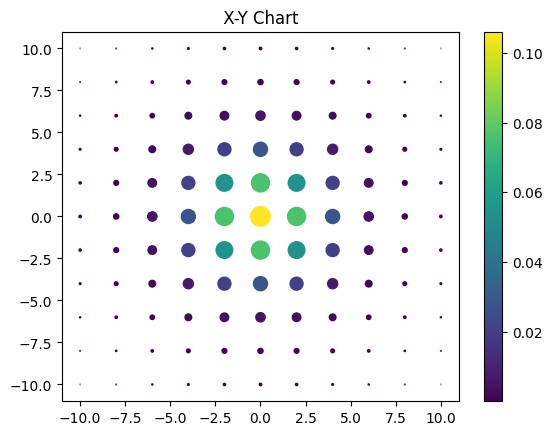

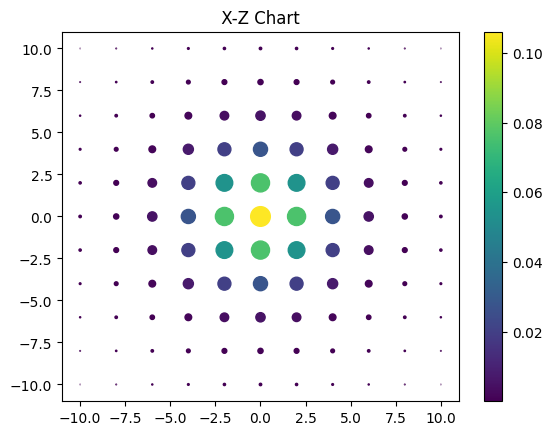

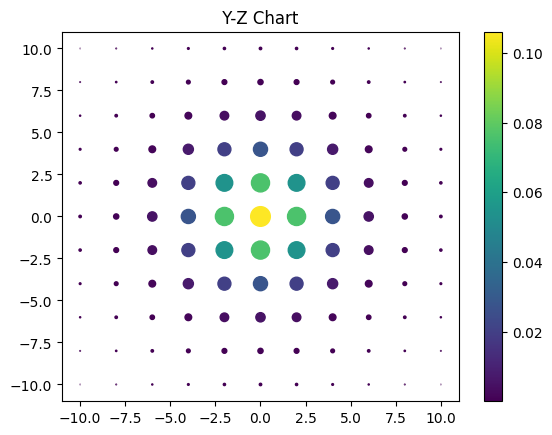

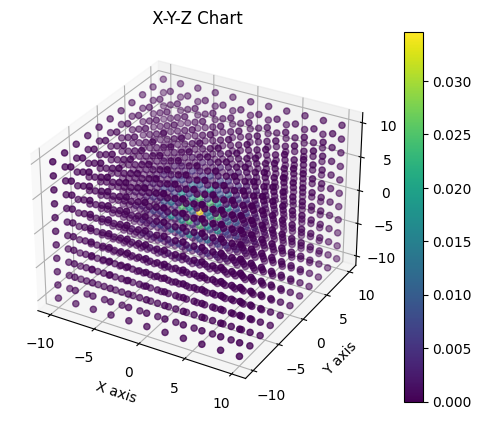

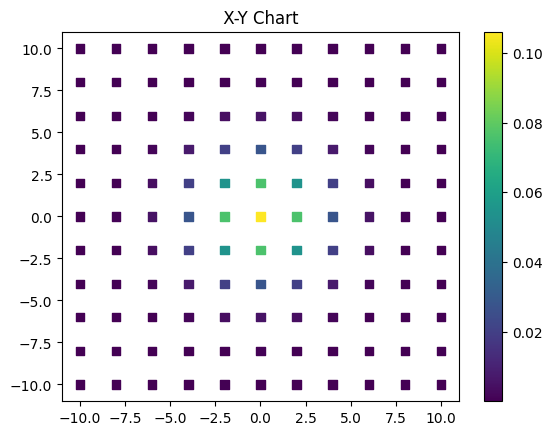

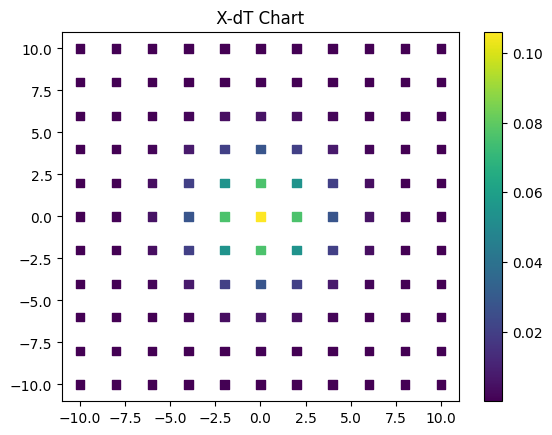

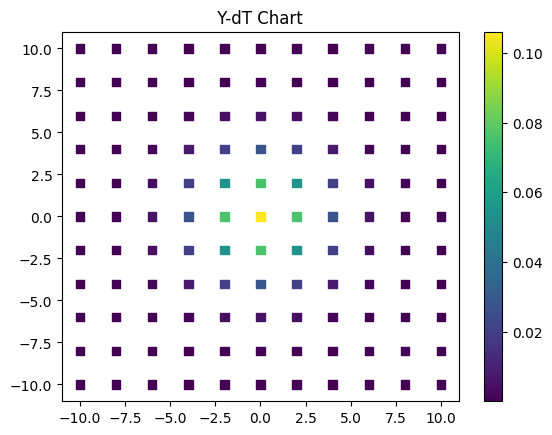

In [48]:
pitch_x = 2
pitch_y = 2
pitch_z = 2
grid_size = 5
chart_scaling = 200
thresh = 1e-20

rv = multivariate_normal([0,0,0], np.diag([pitch_x*3, pitch_x*3, pitch_x*3]))

Dist = getDistribution(grid_size, [0,0,0])

x, y, z, val = np.array(Dist)
data = pd.DataFrame({'x': x.flatten(), 'y': y.flatten(), 
            'dt': z.flatten(), 'Nel': val.flatten()})

plotReadout_1(data)
# plotReadout_2(data)

### Print PDF

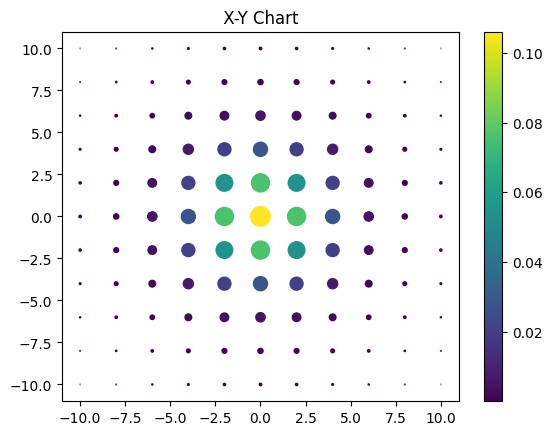

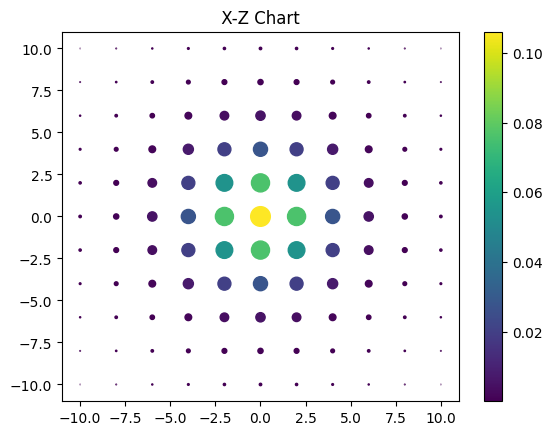

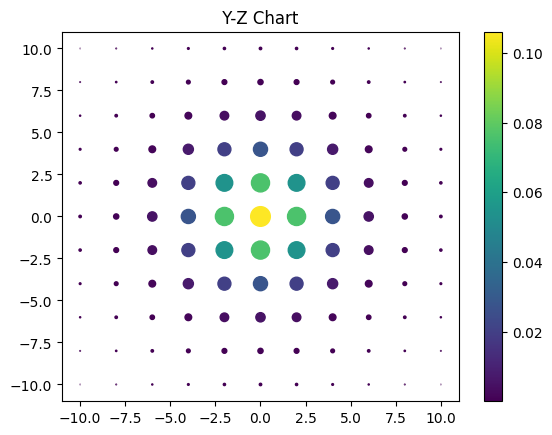

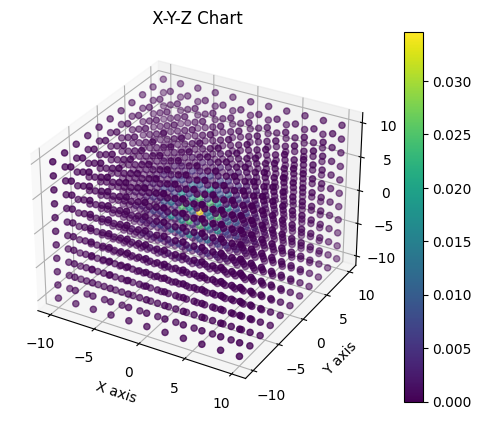

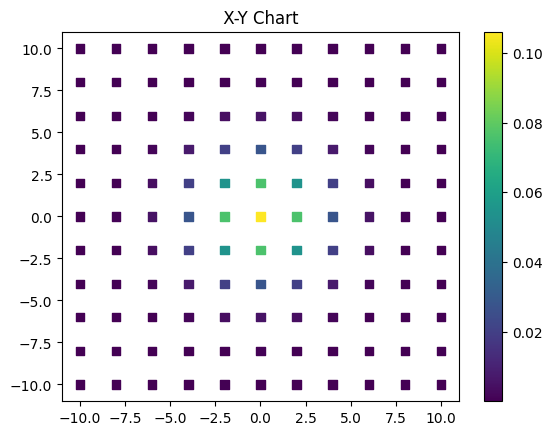

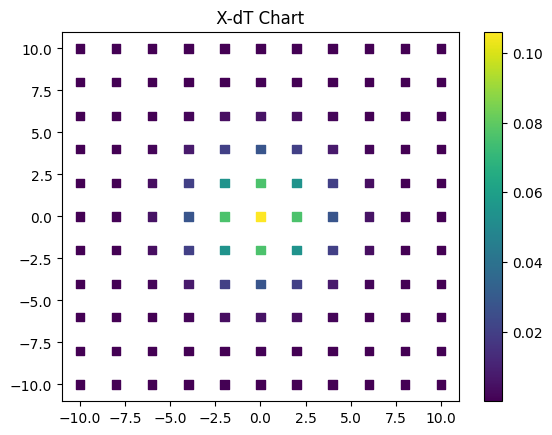

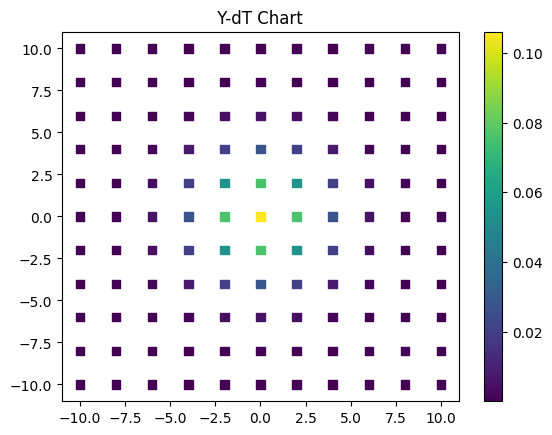

In [44]:
pitch_x = 2
pitch_y = 2
pitch_z = 2
grid_size = 5
chart_scaling = 200
thresh = 1e-20

rv = multivariate_normal([0,0,0], np.diag([pitch_x*3, pitch_x*3, pitch_x*3]))

Dist = getDistribution(grid_size, [0,0,0])

x, y, z, val = np.array(Dist)
data = pd.DataFrame({'x': x.flatten(), 'y': y.flatten(), 
            'dt': z.flatten(), 'Nel': val.flatten()})

plotReadout_1(data)
plotReadout_2(data)

### Initialization

In [105]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
printPrimary(PrimaryEvt)

 x        y        z       Edep   
 23.9622  26.8518  26.8149  0.0437
 23.9624  26.8520  26.8149  0.0838
 23.9623  26.8521  26.8149  0.1366
 23.9621  26.8518  26.8149  0.0494
 23.9614  26.8500  26.8151  0.0220
 23.9576  26.8481  26.8163  0.6658
 23.9568  26.8459  26.8145  0.3760
 23.9573  26.8446  26.8128  0.4339
 23.9571  26.8461  26.8127  0.0160
 23.9577  26.8449  26.8134  1.0524


In [106]:
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)
printPrimaryNIP(PrimaryEvtNIP)

 x       y        z        Edep    NIP
 23.9622  26.8518  26.8149  0.0437  1 
 23.9624  26.8520  26.8149  0.0838  5 
 23.9623  26.8521  26.8149  0.1366  2 
 23.9621  26.8518  26.8149  0.0494  2 
 23.9614  26.8500  26.8151  0.0220  1 
 23.9576  26.8481  26.8163  0.6658  23 
 23.9568  26.8459  26.8145  0.3760  12 
 23.9573  26.8446  26.8128  0.4339  14 
 23.9571  26.8461  26.8127  0.0160  0 
 23.9577  26.8449  26.8134  1.0524  30 


In [110]:
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)
printDrifted(DriftedEvt)

pidx   x        y        dt
0      23.9864  27.0982  26.9531 
1      24.0866  26.8749  26.8472 
1      24.0114  26.8147  26.9359 
1      24.0038  26.8346  26.7663 
1      23.9738  27.0020  26.6570 
1      23.9231  26.9393  26.9744 
2      23.9299  26.8804  27.0358 
2      23.7952  26.9457  27.0787 
3      23.9001  26.8410  26.9372 
3      23.9065  26.7449  26.9658 
4      23.9046  26.8381  26.7056 
5      23.9230  26.9661  26.9281 
5      23.8725  26.9211  26.7811 
5      23.8230  26.7802  26.7890 
5      24.1754  26.7926  26.8388 
5      23.9738  26.8821  26.8167 
5      23.9715  27.0334  26.8809 
5      24.0003  26.9494  26.9038 
5      23.9390  26.8162  26.7881 
5      23.8907  27.0069  26.7066 
5      23.9994  26.8083  26.9641 
5      23.9734  26.9201  26.8230 
5      24.0462  27.0677  26.8501 
5      23.7383  26.6881  26.8094 
5      23.9274  26.9157  26.5510 
5      24.0009  26.8846  26.6853 
5      23.7009  26.9901  26.9209 
5      23.9141  26.7924  26.6038 
5      23.8894  26.9

In [32]:
DriftedArray = np.array([DriftedEvt[1], DriftedEvt[2], DriftedEvt[3]])
coord_1 = np.stack((DriftedArray), axis=-1)
print(coord_1[0])

[23.88099939 26.86978242  0.15814917]


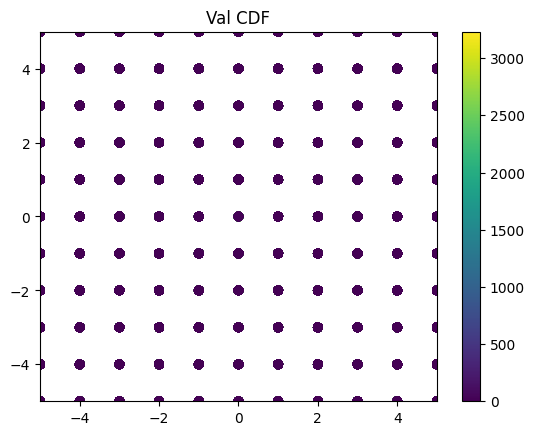

In [38]:
pitch_x = 1
pitch_y = 1
pitch_z = 0.01
grid_size = 100
Dist = getDistribution(100, [0,0,0])

In [70]:
# Function Definition
def getDistribution(grid_size, offset):
        x, y, z = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
                -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y,
                -grid_size*pitch_z:(grid_size+1)*pitch_z:pitch_z,
                ]
        offset_x, offset_y, offset_z = offset

        gain = np.random.exponential(scale=det.gain_mean)
        # top_right = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
        # bottom = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)
        # left = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
        # bottom_left = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)
        val = rv.pdf(np.stack((x, y, z), axis = -1))*pitch_x*pitch_y*pitch_z*gain
        # gain=1 #not considering gain effect for temporary

        # val_cdf = (rv.cdf(top_right) - rv.cdf(bottom) - rv.cdf(left) + rv.cdf(bottom_left))*gain

        # plt.figure(0)
        # plt.title('XY')
        # plt.scatter(x, y, c=val)
        # plt.colorbar()

        # plt.figure(1)
        # plt.title('XZ')
        # plt.scatter(x, z, c=val)
        # plt.colorbar()
        
        # plt.figure(2)
        # plt.title('YZ')
        # plt.scatter(y, z, c=val)
        # plt.colorbar()
        
        
        return x, y, z, val

In [48]:
x, y, z, val = np.array(Dist)
print(np.array(Dist).shape)
print(x.shape)

(4, 201, 201, 201)
(201, 201, 201)


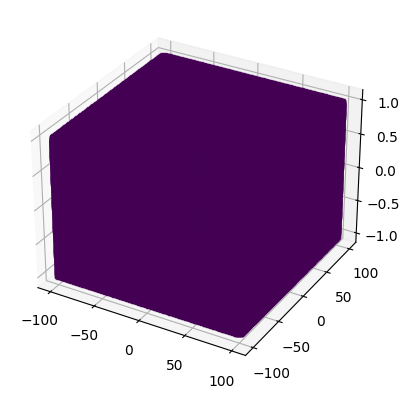

In [49]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the scatter plot data and customize the marker and color
ax.scatter(x, y, z, c=val, marker='s')

In [ ]:

pitch_x = 1
pitch_y = 1
pitch_z = 0.1

grid_size = 100
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))
N = 20

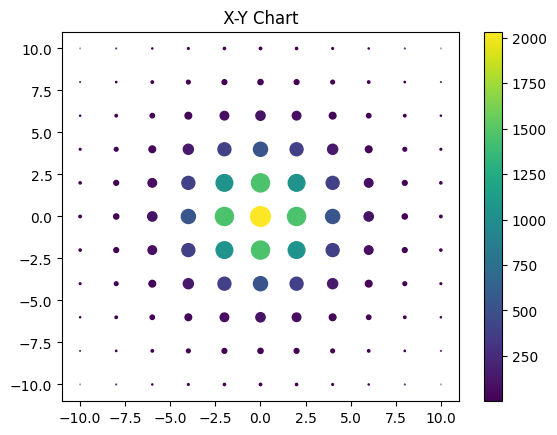

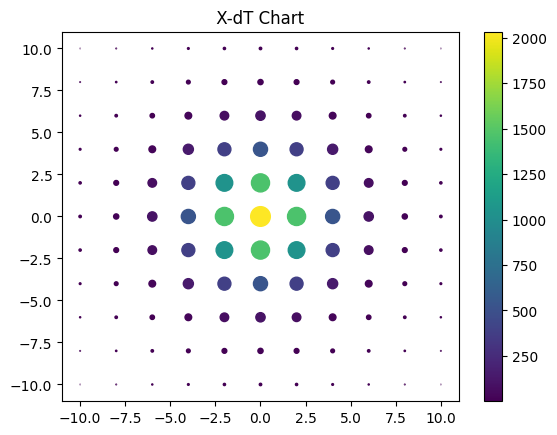

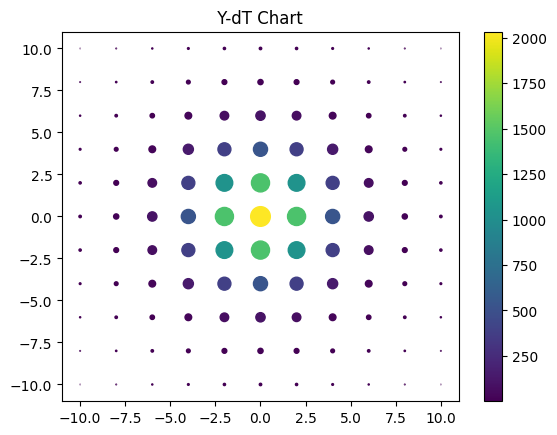

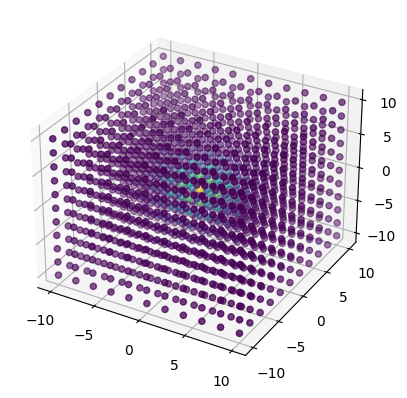

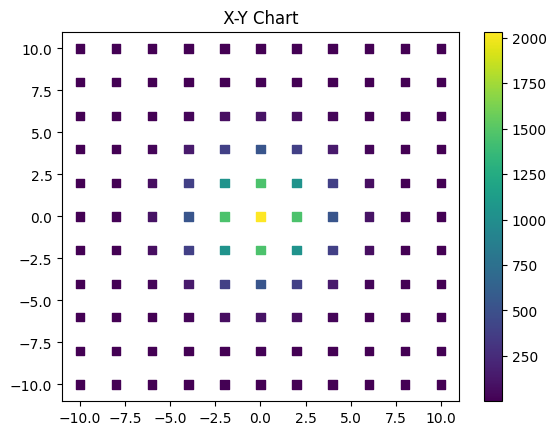

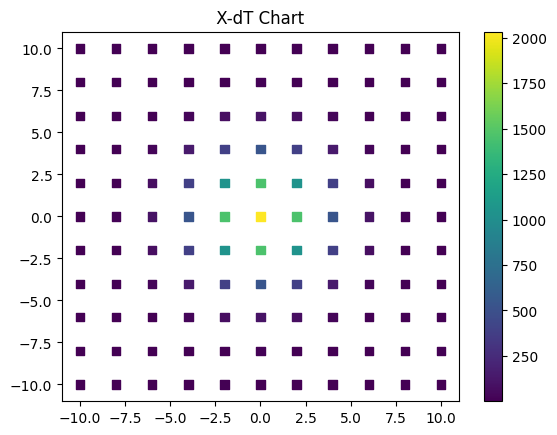

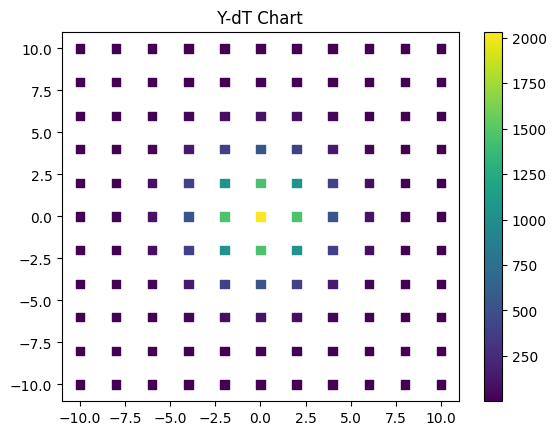

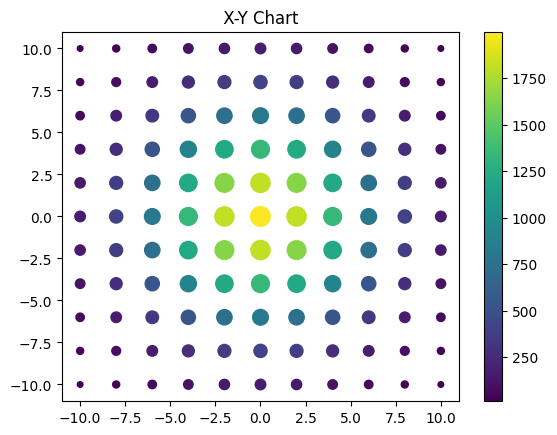

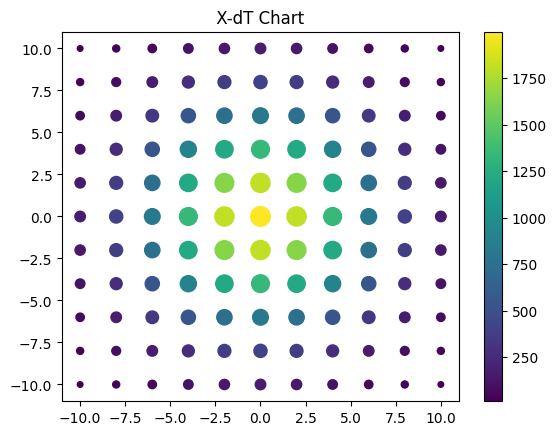

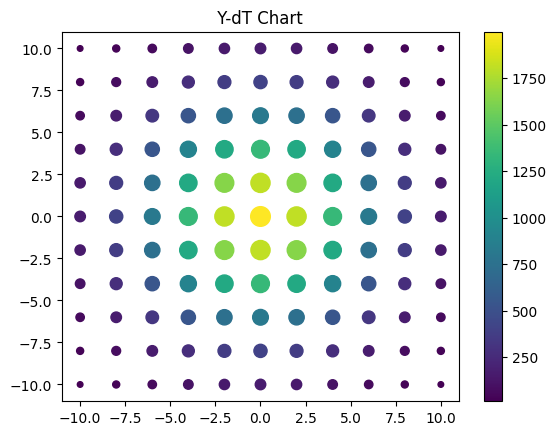

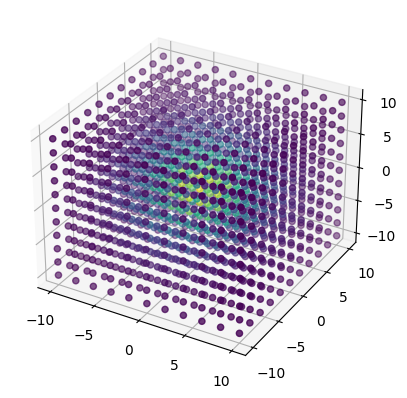

In [117]:
pitch_x = 2
pitch_y = 2
pitch_z = 2
grid_size = 5
a = 10
thresh = 1e-20

rv = multivariate_normal([0,0,0], np.diag([a*pitch_x, a*pitch_y, a*pitch_z]))

Dist = getDistribution(grid_size, [0,0,0])

x, y, z, val = np.array(Dist)
data = pd.DataFrame({'x': x.flatten(), 'y': y.flatten(), 
            'dt': z.flatten(), 'Nel': val.flatten()})

plotReadout_1(data)
# plotReadout_2(data)

In [123]:
ReadoutEvt = np.array(ReadoutGain(DriftedArray))

[0.15814917 0.15899605 0.15793129] [26.86978242 26.73958789 26.76221577]


In [125]:
print(ReadoutEvt.shape)

(4, 700)


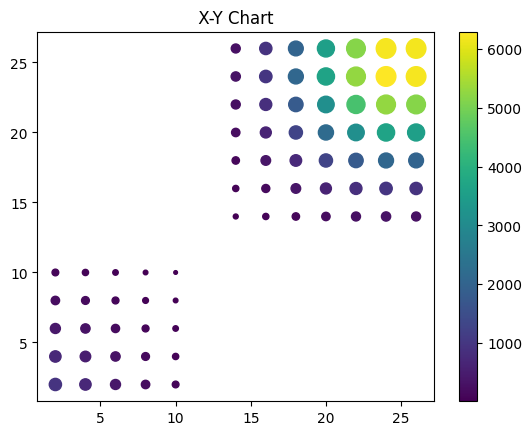

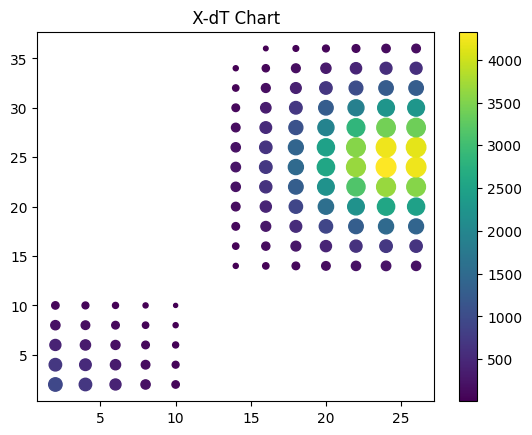

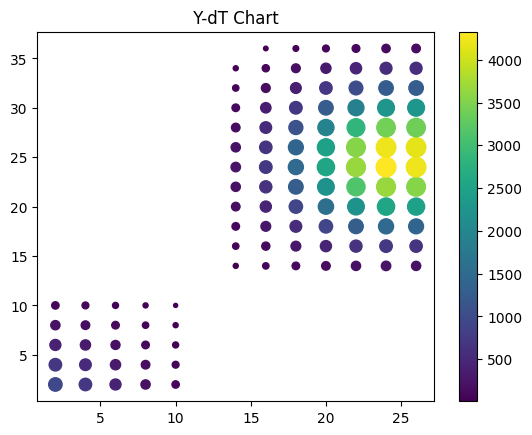

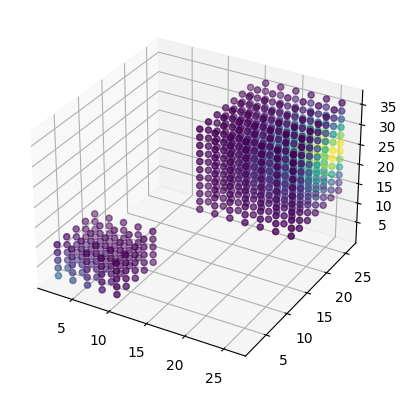

In [126]:

event = np.array(ReadoutEvt)
x, y, z, val = event
data = pd.DataFrame({'x': event[0], 'y': event[1], 
            'dt': event[2], 'Nel': event[3]})
chart_scaling = 200

plotReadout_1(data)

In [127]:
print(data)

        x     y    dt       Nel
0    14.0  14.0  14.0  0.372897
1    14.0  14.0  16.0  0.917178
2    14.0  14.0  18.0  1.846969
3    14.0  14.0  20.0  3.045137
4    14.0  14.0  22.0  4.110505
..    ...   ...   ...       ...
695  10.0  10.0   2.0  3.094687
696  10.0  10.0   4.0  2.292601
697  10.0  10.0   6.0  1.390533
698  10.0  10.0   8.0  0.690518
699  10.0  10.0  10.0  0.280744

[700 rows x 4 columns]
